# HA-ES Plotting

- udpated version of plotting script used for paper "..."

## General

- imports
- defintions
- loading data

In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygmo as pg
import seaborn as sns

import math
import os

from autorank._util import get_sorted_rank_groups
from autorank import autorank, plot_stats
from tabrepo import load_repository

method_id_name_dict = {
    "GES": "GES",
    "MULTI_GES": "Multi-GES",
    "QO": "QO-ES",
    "QDO": "QDO-ES",
    "ENS_SIZE_QDO": "Size-QDO-ES",
    "INFER_TIME_QDO": "Infer-QDO-ES",
}

print("Loading data. This might take a while...")
df = pd.read_json("../data/full.json")

# Map method IDs to names
if "method" in df.columns:
    df["method_name"] = df["method"].map(method_id_name_dict)
else:
    raise ValueError("Column 'method' not found in DataFrame")
print(df.shape)
print(df.columns)
print(df["method"].unique())
context_name = "D244_F3_C1530_30"
repo = load_repository(context_name, cache=True)
df["models_used_length"] = df["models_used"].apply(len)

Loading data. This might take a while...
(36583, 17)
Index(['name', 'iteration', 'roc_auc_val', 'roc_auc_test', 'models_used',
       'weights', 'task', 'dataset', 'fold', 'method', 'task_id', 'seed',
       'time_weight', 'inference_time', 'negated_normalized_roc_auc',
       'normalized_time', 'method_name'],
      dtype='object')
['GES' 'MULTI_GES']


## Helper Functions

### Boxplot:

In [2]:
def boxplot(
    df: pd.DataFrame,
    y_str: str,
    log_y_scale: bool = False,
    log_x_scale: bool = False,
    flip_y_axis: bool = False,
    orient: str = "v",
    rotation_x_ticks: int = 45,
):
    if y_str not in df.columns:
        raise ValueError(f"Column '{y_str}' not found in DataFrame")

    # Plot ROC AUC scores for each method
    plt.figure(figsize=(8, 6))
    if orient == "v":
        sns.boxplot(
            data=df,
            x='method_name',  # or y='method_name' based on 'orient'
            y=y_str,
            hue='method_name',  # Assigning the variable to hue
            palette='pastel',
            linewidth=2,
            orient=orient,
            legend=False  # Set legend to False if you don't need it
        )
    elif orient == "h":
        sns.boxplot(
            data=df,
            x=y_str,
            y='method_name',  # or y='method_name' based on 'orient'
            hue='method_name',  # Assigning the variable to hue
            palette='pastel',
            linewidth=2,
            orient=orient,
            legend=False  # Set legend to False if you don't need it
        )
    else:
        raise ValueError(f"Orient '{orient}' not supported")
    # plt.title("Performance of Ensemble Methods: " + y_str, fontsize=20)

    if orient == "v":
        plt.ylabel(y_str)
        plt.xlabel("Ensemble Method")
    elif orient == "h":
        plt.xlabel(y_str)
        plt.ylabel("Ensemble Method")

    if log_y_scale:
        plt.yscale("log")
    if log_x_scale:
        plt.xscale("log")
    if flip_y_axis:
        plt.gca().invert_yaxis()
    if flip_y_axis:
        plt.gca().invert_yaxis()
    plt.xticks(rotation=rotation_x_ticks)
    plt.grid(True)
    plt.tight_layout()
    
    # Check if the directory exists, if not, create it
    directory = "../plots"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # save to file
    plt.savefig(f"{directory}/boxplot_{y_str}.png", dpi=300, bbox_inches="tight")
    plt.savefig(f"{directory}/boxplot_{y_str}.pdf", dpi=300, bbox_inches="tight")
    plt.show()
    
import ipywidgets as widgets
    
def interactive_boxplot(df, column_options):
    y_str_widget = widgets.Dropdown(options=column_options, description='Y-axis column:', style={'description_width': 'initial'})
    log_y_scale_widget = widgets.Checkbox(value=False, description='Log-scale Y-axis')
    log_x_scale_widget = widgets.Checkbox(value=False, description='Log-scale X-axis')
    flip_y_axis_widget = widgets.Checkbox(value=False, description='Flip Y-axis')
    orient_widget = widgets.RadioButtons(options=['v', 'h'], value='h', description='Orientation:', style={'description_width': 'initial'})
    rotation_x_ticks_widget = widgets.IntSlider(value=0, min=0, max=90, step=5, description='Rotation X-ticks')

    ui = widgets.VBox([
        y_str_widget,
        log_y_scale_widget,
        log_x_scale_widget,
        flip_y_axis_widget,
        orient_widget,
        rotation_x_ticks_widget
    ])

    out = widgets.interactive_output(boxplot, {
        'df': widgets.fixed(df),
        'y_str': y_str_widget,
        'log_y_scale': log_y_scale_widget,
        'log_x_scale': log_x_scale_widget,
        'flip_y_axis': flip_y_axis_widget,
        'orient': orient_widget,
        'rotation_x_ticks': rotation_x_ticks_widget
    })

    display(ui, out)

### Critical Difference:

In [3]:

def cd_evaluation(
    hypervolumes,
    maximize_metric=True,
    plt_title="Critical Difference Plot",
    filename="CriticalDifferencePlot.png",
):
    """
    hypervolumes: DataFrame with method names as columns and tasks as rows, each cell contains hypervolume.
    maximize_metric: Boolean, True if higher values are better.
    output_path: Where to save the plot, if None, plot will not be saved.
    plt_title: Title of the plot.
    """
    # Prepare data
    rank_data = -hypervolumes if maximize_metric else hypervolumes

    # Run autorank
    result = autorank(rank_data, alpha=0.05, verbose=False, order="ascending")

    # Plot with updated font size
    plt.close("all")
    width = 6
    fig, ax = plt.subplots(figsize=(12, width))
    plt.rcParams.update({"font.size": 20})

    plot_stats(result, ax=ax)
    ax.tick_params(axis="both", labelsize=20)  # Set font size for axis ticks
    labels = [item.get_text() for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels, fontsize=20)  # Adjust fontsize as needed
    plt.tight_layout()

    plt.savefig(filename, bbox_inches="tight", dpi=300)
    plt.close()

    return result


## Pareto Fronts/Scatter Plots

TODO: Pareto Fronts

In [4]:
def plot_task_data(df, directory='plots/scatter'):
    # Create a directory to save the plots if it doesn't exist
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    # Define the unique tasks to create separate plots
    tasks = df['task'].unique()
    
    # Set the overall aesthetics for the plots
    sns.set(style="whitegrid")
    
    # Iterate over each task to create and save a plot
    for task in tasks:
        plt.figure(figsize=(10, 8))  # Define a new figure for each task
        
        # Filter the dataframe by task
        task_data = df[df['task'] == task]
        
        # Scatter plot using seaborn to easily differentiate between methods
        scatter = sns.scatterplot(
            data=task_data, 
            x='normalized_time', 
            y='negated_normalized_roc_auc', 
            hue='method',  # Differentiate by color
            size='models_used_length', 
            sizes=(20, 200),  # Control the range of sizes of markers
            legend='brief',  # Simplified legend
            palette='viridis'  # Use a color palette that is visually appealing
        )
        scatter.set_title(f'Task: {task}')
        scatter.set_xlabel('Normalized Time')
        scatter.set_ylabel('Negated Normalized ROC AUC')
        
        # Simplify the legend: show only methods in legend
        handles, labels = scatter.get_legend_handles_labels()
        # Only keep the legend handles that correspond to 'method'
        method_handles = handles[1:len(df['method'].unique())+1]
        method_labels = labels[1:len(df['method'].unique())+1]
        scatter.legend(method_handles, method_labels, title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # Save the plot to the specified directory
        plt.savefig(f"{directory}/Task_{task}.png", bbox_inches='tight')
        plt.close()

In [5]:
plot_task_data(df, directory="../plots/scatter")
print("Done")

Done


We can view some samples of the results with the following code. For both metrics applies: lower is better.

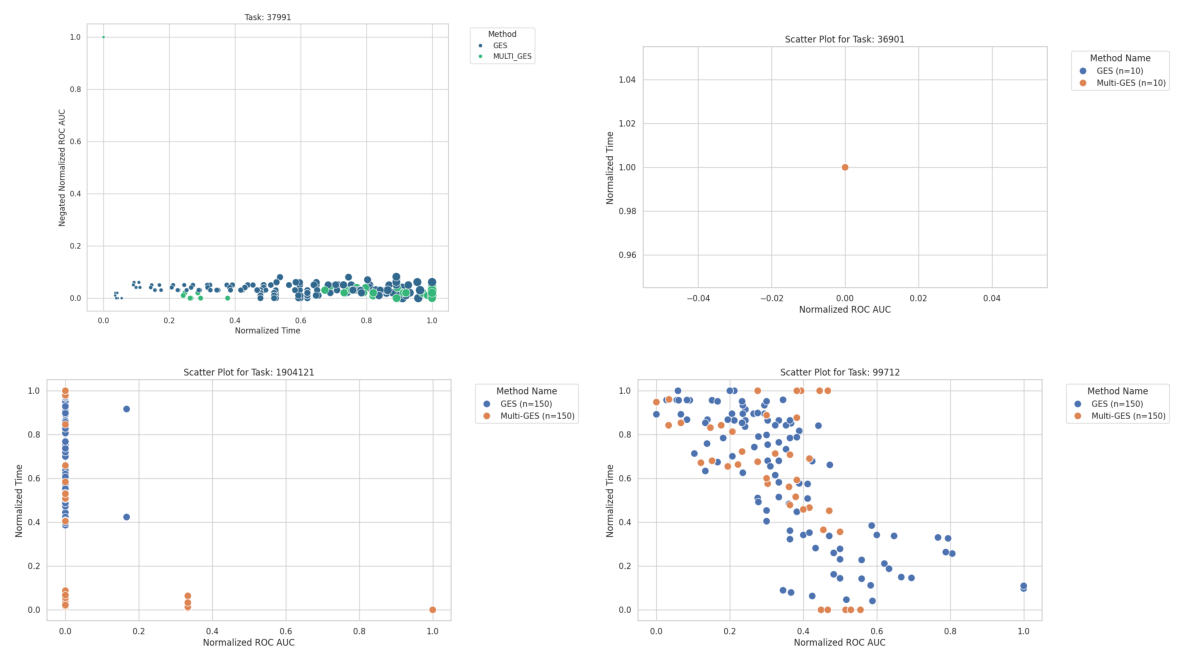

In [6]:
import matplotlib.image as mpimg
import random


# Get a list of all files in the directory and filter for PNG files
dir_path = '../plots/scatter/'
all_files = [os.path.join('../plots/scatter/', file) for file in os.listdir(dir_path) if file.endswith('.png')]

# Randomly pick four images
selected_images = random.sample(all_files, 4)

# Set up the figure and axes
fig, axs = plt.subplots(2, 2, figsize=(12, 7)) 
axs = axs.flatten()
for ax, img_path in zip(axs, selected_images):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.axis('off') 
plt.tight_layout()
plt.show()

## Data Exploration

In [7]:
column_options = ['models_used_length', 'roc_auc_test', 'negated_normalized_roc_auc']

interactive_boxplot(df, column_options)

Output()

### Histograms

In [8]:
def plot_evaluation_metrics(df, metric_name):
    plt.figure(figsize=(12, 8))
    
    # Create a copy of the DataFrame to avoid SettingWithCopyWarning
    plot_data = df.copy()
    # Ensure the metric is between 0 and 1 for consistent plotting
    plot_data[metric_name] = plot_data[metric_name].clip(0, 1)
    
    # Generate the plot
    ax = sns.histplot(
        data=plot_data, 
        x=metric_name, 
        hue="time_weight", 
        element="step", 
        stat="density", 
        common_norm=False, 
        palette="viridis",  # Use viridis for color gradient
        line_kws={'linewidth': 2},  # Increase line width for better visibility
        kde=True
    )
    
    # Create the colorbar with proper referencing of the axes
    norm = plt.Normalize(plot_data['time_weight'].min(), plot_data['time_weight'].max())
    sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, label='Time Weight')

    plt.title(f'Distribution of {metric_name} Across Different Time Weights')
    plt.xlabel(metric_name)
    plt.ylabel('Density (log scale)')
    plt.grid(True, which="both", ls="--")  # Grid for both major and minor ticks
    plt.show()

def plot_time_weight_impact(df):
    # Filter to include only rows where the method is 'MULTI_GES'
    multi_ges_data = df[df['method'] == 'MULTI_GES']

    # Plot for normalized time
    plot_evaluation_metrics(multi_ges_data, 'normalized_time')

    # Plot for performance score, assuming 'negated_normalized_roc_auc' is the performance metric
    plot_evaluation_metrics(multi_ges_data, 'negated_normalized_roc_auc')

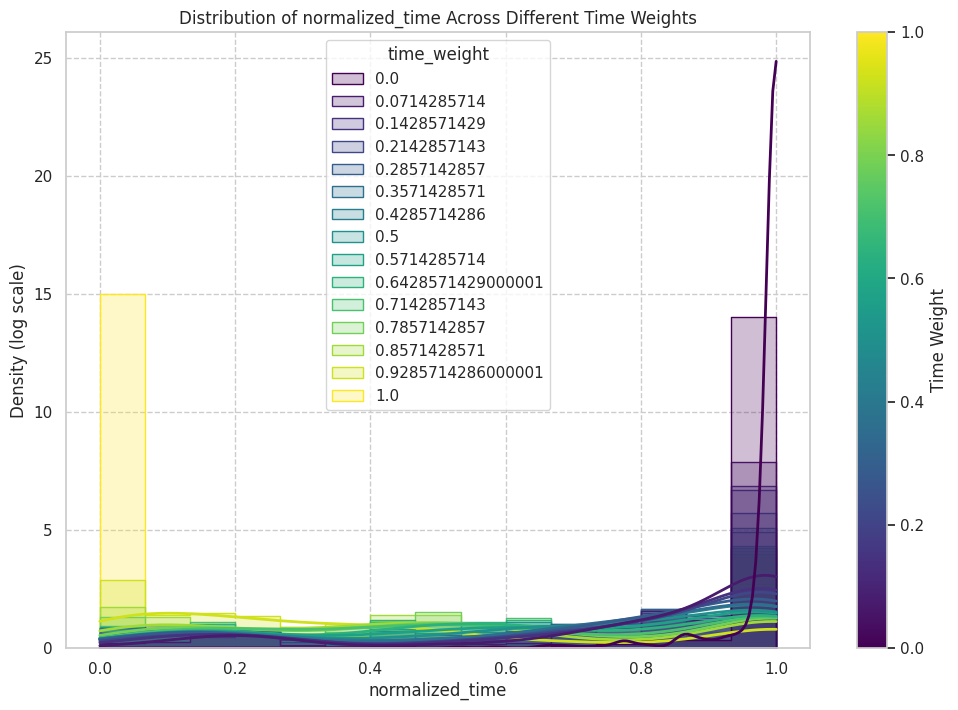

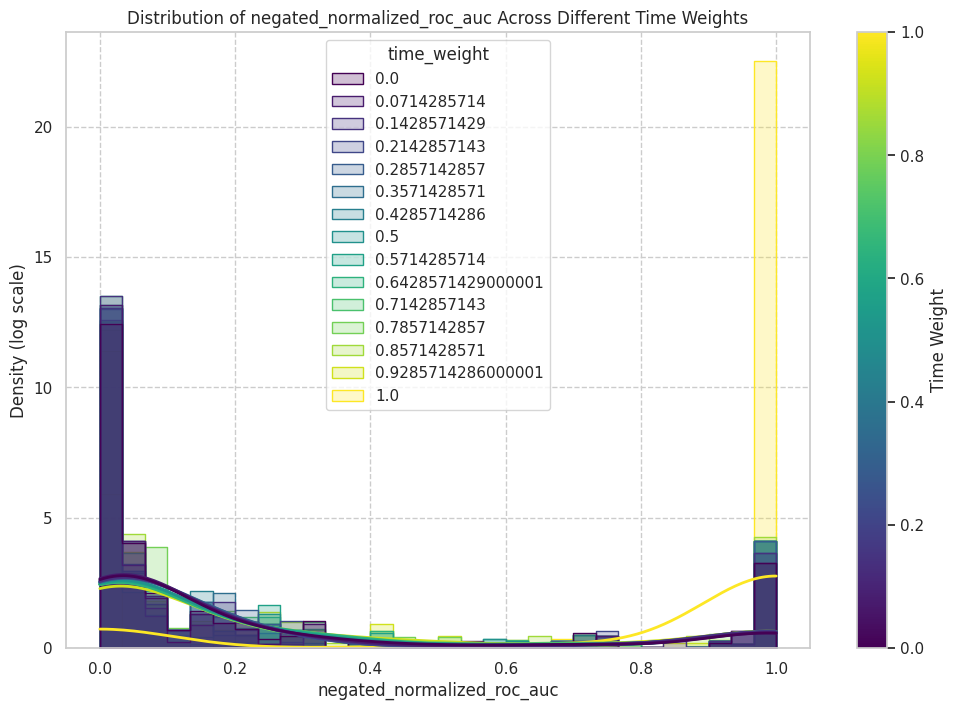

In [9]:
plot_time_weight_impact(df)

Time weight has impact on resutls

In [10]:
def plot_metrics_histogram(df):
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    
    # Adjusting bins to actual range and not bin index
    x_edges = np.linspace(0, 1, 20)  # normalized_time from 0 to 1
    y_edges = np.linspace(0, 1, 20)  # negated_normalized_roc_auc from 0 to 1
    
    # Density Plot
    ax1 = axes[0]
    sns.histplot(df, x='normalized_time', y='negated_normalized_roc_auc', bins=[x_edges, y_edges], cbar=True, ax=ax1, stat="density")
    ax1.set_title('Density per Bin')
    ax1.set_xlabel('Normalized Time')
    ax1.set_ylabel('Negated Normalized ROC AUC')
    ax1.set_ylim([0, 1])  # Correcting y-axis scale

    # Average Time Weight Plot
    ax2 = axes[1]
    df['x_bin'] = pd.cut(df['normalized_time'], bins=x_edges, labels=np.round(np.linspace(0, 1, 19), 2))
    df['y_bin'] = pd.cut(df['negated_normalized_roc_auc'], bins=y_edges, labels=np.round(np.linspace(0, 1, 19), 2))
    
    grouped = df.groupby(['x_bin', 'y_bin'])['time_weight'].mean().reset_index()
    grouped['x_bin'] = grouped['x_bin'].astype(float)
    grouped['y_bin'] = grouped['y_bin'].astype(float)

    heatmap_data = grouped.pivot_table(index='y_bin', columns='x_bin', values='time_weight')
    sns.heatmap(heatmap_data, ax=ax2, cbar=True, cmap='viridis', annot=True)
    ax2.set_title('Average Time Weight per Bin')
    ax2.set_xlabel('Normalized Time')
    ax2.set_ylabel('Negated Normalized ROC AUC')
    ax2.set_ylim([0, 19])  # Correcting y-axis scale for display
    
    plt.tight_layout()
    plt.show()

(9900, 18)


/tmp/ipykernel_30451/3210613122.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x_bin'] = pd.cut(df['normalized_time'], bins=x_edges, labels=np.round(np.linspace(0, 1, 19), 2))
/tmp/ipykernel_30451/3210613122.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y_bin'] = pd.cut(df['negated_normalized_roc_auc'], bins=y_edges, labels=np.round(np.linspace(0, 1, 19), 2))
/tmp/ipykernel_30451/3210613122.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in 

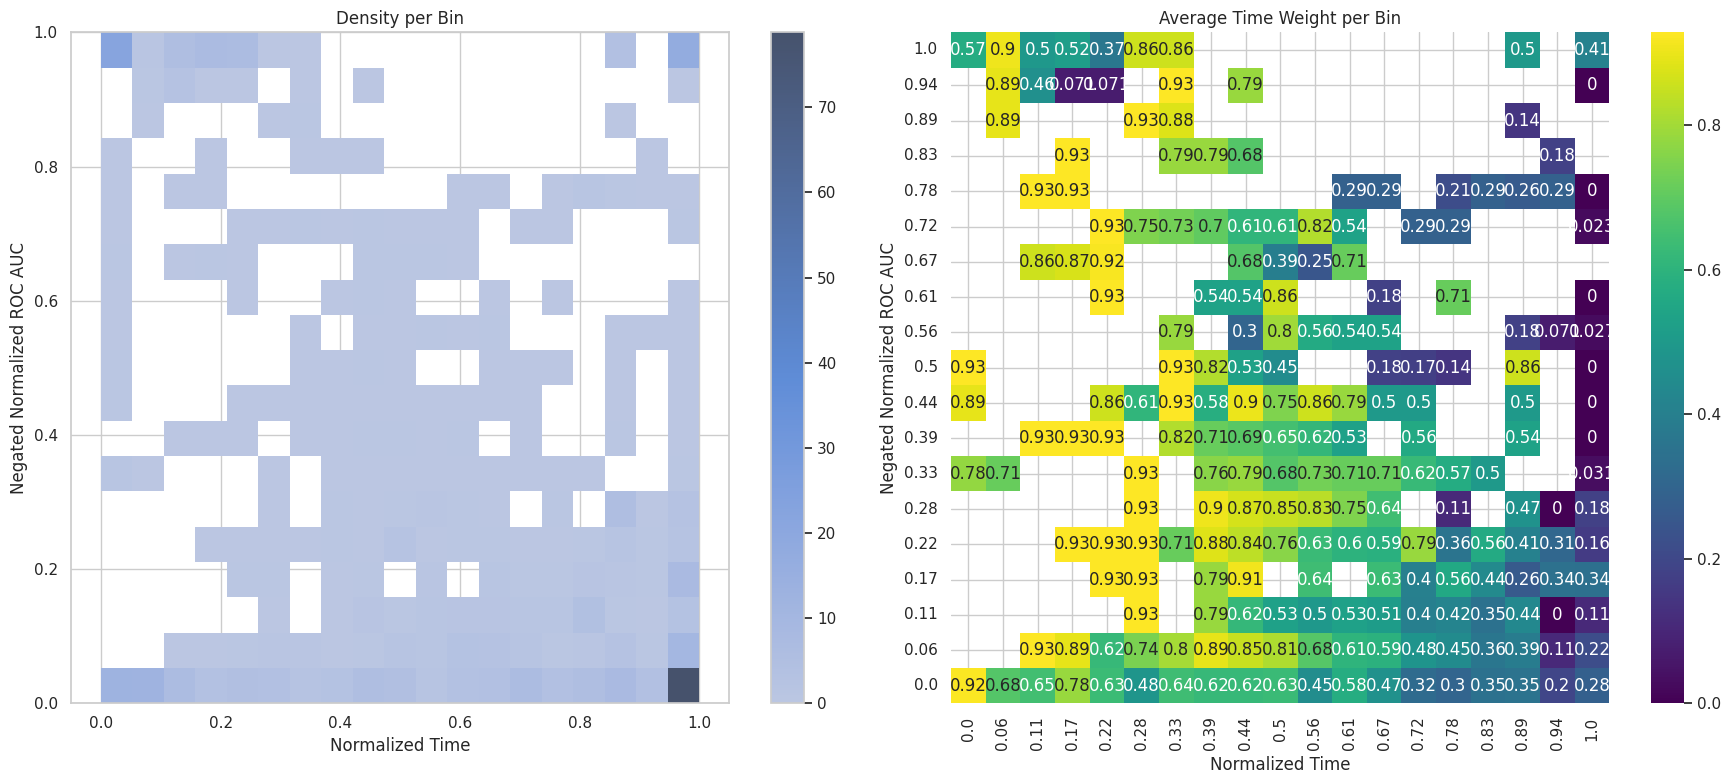

In [11]:
multi_ges_df = df.loc[df["method"] == "MULTI_GES"]
print(multi_ges_df.shape)
plot_metrics_histogram(multi_ges_df)

## Hypervolume

In [12]:
def is_pareto_efficient(costs, return_mask=True):
    is_efficient = np.ones(costs.shape[0], dtype=bool)
    for i, c in enumerate(costs):
        is_efficient[i] = not np.any(
            np.all(costs <= c, axis=1) & np.any(costs < c, axis=1)
        )
    return is_efficient if return_mask else costs[is_efficient]


def calculate_average_hypervolumes(df, method_name):
    df_method = df[df["method_name"] == method_name]
    hypervolumes = {}

    # Iterate over unique task_ids
    for task_id in df_method["task_id"].unique():
        seed_hypervolumes = []  # Store hypervolumes for each seed

        for seed in df_method["seed"].unique():
            fold_hypervolumes = []  # Store hypervolumes for each fold under the current seed

            for fold in df_method["fold"].unique():
                df_fold = df_method[
                    (df_method["task_id"] == task_id)
                    & (df_method["seed"] == seed)
                    & (df_method["fold"] == fold)
                ]

                objectives = np.array(
                    [
                        df_fold["negated_normalized_roc_auc"].values,
                        df_fold["normalized_time"].values,
                    ]
                ).T
                is_efficient = is_pareto_efficient(objectives)
                efficient_objectives = objectives[is_efficient]

                ref_point = [
                    1.01,
                    1.01,
                ]  # Reference point beyond the worst values of objectives
                hv = pg.hypervolume(efficient_objectives)
                hypervolume = hv.compute(ref_point)
                fold_hypervolumes.append(hypervolume)

            # Average hypervolumes across all folds for a given seed
            if fold_hypervolumes:
                average_fold_hypervolume = np.mean(fold_hypervolumes)
                seed_hypervolumes.append(average_fold_hypervolume)

        # Average the averaged fold hypervolumes across seeds
        if seed_hypervolumes:
            average_seed_hypervolume = np.mean(seed_hypervolumes)
            hypervolumes[task_id] = average_seed_hypervolume

    return hypervolumes


def find_non_dominated(points):
    """Identify the indices of non-dominated points."""
    is_efficient = np.ones(points.shape[0], dtype=bool)
    for i, c in enumerate(points):
        is_efficient[i] = not np.any(
            np.all(points <= c, axis=1) & np.any(points < c, axis=1)
        )
    return np.where(is_efficient)[0]


def plot_hypervolumes(all_hypervolumes, directory: str = "../plots/"):
    # Prepare the data for plotting
    methods = list(all_hypervolumes.keys())  # Method names
    hv_values = [list(all_hypervolumes[method].values()) for method in methods]
    data = []

    # Creating a DataFrame suitable for Seaborn
    for method_index, values in enumerate(hv_values):
        for value in values:
            data.append({"Method": methods[method_index], "Hypervolume": value})
    df = pd.DataFrame(data)

    # Set the figure size and style
    sns.set(
        style="whitegrid"
    )  # Set the background to a white grid for better visibility
    plt.figure(figsize=(8, 6))

    # Use seaborn's boxplot to plot the DataFrame and create an axis object
    ax = sns.boxplot(
        y="Method", x="Hypervolume", data=df, hue='Method', palette="Set2", orient="h"
    )  # You can choose a palette that fits your taste

    # Set titles and labels using the axis object
    # ax.set_title("Comparison of Hypervolume by Method", fontsize=20, fontweight="bold")
    ax.set_ylabel("Method", fontsize=20)
    ax.set_xlabel("Hypervolume", fontsize=20)

    # Set font size for ticks directly on the axes
    ax.tick_params(
        axis="x", labelrotation=45, labelsize=16
    )  # Rotate x-ticks to avoid overlap
    ax.tick_params(axis="y", labelsize=16)

    plt.tight_layout()  # Adjust the plot to fit into the figure area nicely
    plt.savefig(
        directory + "hypervolume_comparison.pdf", dpi=300
    )  # Save the figure with high resolution
    plt.savefig(
        directory + "hypervolume_comparison.png", dpi=300
    )  # Save the figure with high resolution
    plt.show()
    plt.close()

Plotting 

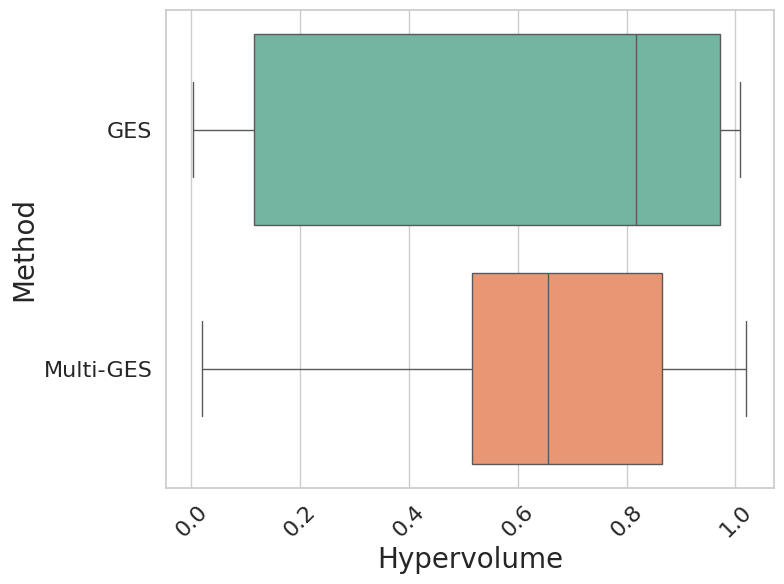

In [13]:

# Hypervolume
methods = [
    "GES",
    "Multi-GES",
]  # "QO-ES", "QDO-ES", "Size-QDO-ES", "Infer-QDO-ES"]
all_hypervolumes = {}

for method in methods:
    all_hypervolumes[method] = calculate_average_hypervolumes(df, method)
plot_hypervolumes(all_hypervolumes)
hypervolumes_df = pd.DataFrame(all_hypervolumes)
hypervolumes_df.to_csv("../data/hypervolumes.csv", index=False)


Method       GES  Multi-GES
Task                       
11      0.668850   0.867784
37      0.949767   0.419482
3583    0.003433   0.686767
3608    1.008038   0.954981
3616    0.044362   1.020100
Index(['GES', 'Multi-GES'], dtype='object', name='Method')
(22, 2)


ValueError: result is not significant and results of the plot may be misleading. If you want to create the plot regardless, use the allow_insignificant parameter to suppress this exception.

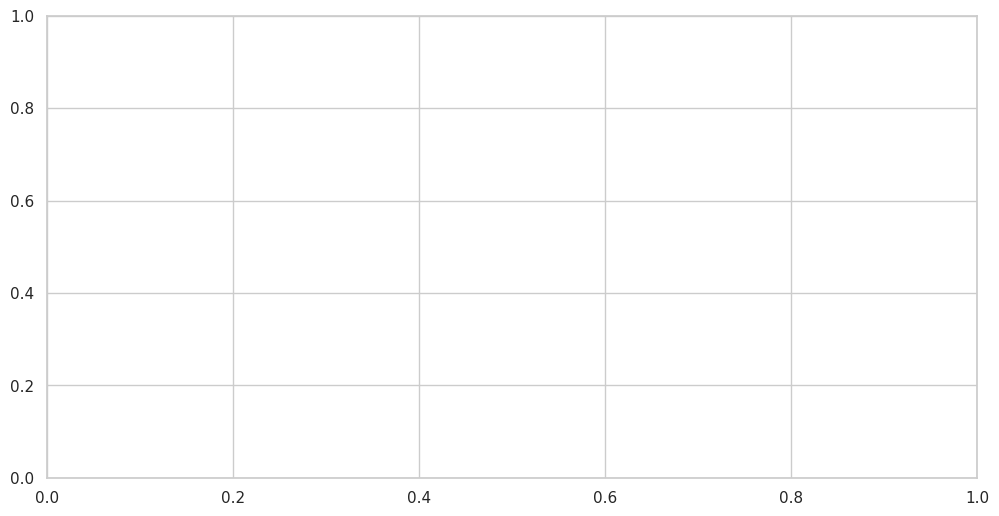

In [14]:
data = []
for method, tasks in all_hypervolumes.items():
    for task_id, hypervolume in tasks.items():
        data.append(
            {"Task": task_id, "Method": method, "Hypervolume": hypervolume}
        )

df_hypervolumes = pd.DataFrame(data)
pivot_hypervolumes = df_hypervolumes.pivot(
    index="Task", columns="Method", values="Hypervolume"
)
print(pivot_hypervolumes.head())
print(pivot_hypervolumes.columns)
print(pivot_hypervolumes.shape)

# Now you can use the modified cd_evaluation function
result = cd_evaluation(
    pivot_hypervolumes,
    maximize_metric=True,
    plt_title="Hypervolume Critical Difference Plot",
    filename="plots/CDPHypervolumes.pdf",
)
result = cd_evaluation(
    pivot_hypervolumes,
    maximize_metric=True,
    plt_title="Hypervolume Critical Difference Plot",
    filename="plots/CDPHypervolumes.png",
)
print(df.columns)

## Ranking

In [ ]:
# DF with the best solution per task_id, fold, seed and method
print("Picking best solutions...")
idx = df.groupby(["method_name", "task_id", "fold", "seed"])[
    "roc_auc_val"
].idxmax()

# Use these indices to get the rows with the maximum 'roc_auc_val' for each group
best_val_scores = df.loc[idx]

print("Averaging over folds...")
avg_over_folds = (
    best_val_scores.groupby(["task_id", "method_name", "seed"])
    .agg(
        {
            "roc_auc_val": "mean",
            "roc_auc_test": "mean",
            "inference_time": "mean",
        }
    )
    .reset_index()
)
print("Averaging over seeds...")
avg_over_seeds = (
    avg_over_folds.groupby(["task_id", "method_name"])
    .agg(
        {
            "roc_auc_val": "mean",
            "roc_auc_test": "mean",
            "inference_time": "mean",
            "name": "first",
        }
    )
    .reset_index()
)

# Plot boxplot for inference time and performance
print(f"Shape after averaging: {avg_over_seeds.shape}")
boxplot(
    avg_over_seeds,
    "inference_time",
    log_x_scale=True,
    orient="h",
    rotation_x_ticks=0,
)

# Rank data within each task based on 'roc_auc_test' and add as a new column
avg_over_seeds["rank"] = avg_over_seeds.groupby("task_id")["roc_auc_test"].rank(
    "dense", ascending=False
)
boxplot(avg_over_seeds, "rank", flip_y_axis=True)
avg_over_seeds["negated_roc_auc_test"] = 1 - avg_over_seeds["roc_auc_test"]
pivot_ranks = avg_over_seeds.pivot(
    index="task_id", columns="method_name", values="negated_roc_auc_test"
)
cd_evaluation(
    pivot_ranks,
    maximize_metric=False,
    plt_title="Rankings Critical Difference Plot",
    filename="plots/CDPRankings.pdf",
)
cd_evaluation(
    pivot_ranks,
    maximize_metric=False,
    plt_title="Rankings Critical Difference Plot",
    filename="plots/CDPRankings.png",
)

## Inference Time

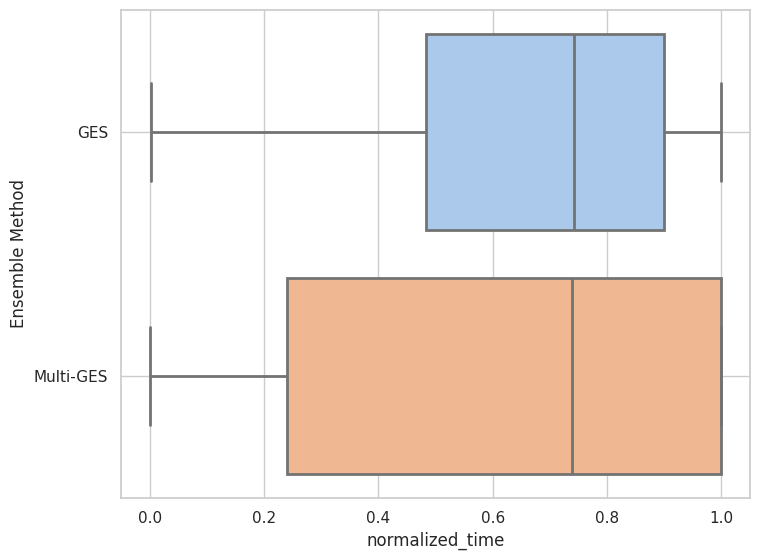

In [15]:
boxplot(
    df,
    "normalized_time",
    log_x_scale=False,
    orient="h",
    rotation_x_ticks=0,
)

Higher variance for Multi-GES due to varying time weight

## Latex Table

In [ ]:

def create_latex_table(df, repo, filename="table.tex", max_char=15):
    methods = df["method_name"].unique()
    task_ids = df["task_id"].unique()

    with open(filename, "w") as f:
        f.write("\\begin{longtable}{l" + "c" * len(methods) + "}\n")
        f.write(
            "\\caption{Test ROC AUC - Binary: The mean and standard deviation of the test score over all folds for each method. The best methods per dataset are shown in bold. All methods close to the best method are considered best (using NumPy’s default \\texttt{isclose} function).}\n"
        )
        f.write("\\label{tab:results} \\\\ \n")
        f.write("\\toprule\n")
        f.write("Dataset & " + " & ".join(map(str, methods)) + " \\\\\n")
        f.write("\\midrule\n")
        f.write("\\endfirsthead\n")
        f.write("\\toprule\n")
        f.write("Dataset & " + " & ".join(map(str, methods)) + " \\\\\n")
        f.write("\\midrule\n")
        f.write("\\endhead\n")
        f.write("\\midrule\n")
        f.write(
            "\\multicolumn{"
            + str(len(methods) + 1)
            + "}{r}{Continued on next page} \\\\\n"
        )
        f.write("\\midrule\n")
        f.write("\\endfoot\n")
        f.write("\\bottomrule\n")
        f.write("\\endlastfoot\n")

        for task_id in task_ids:
            dataset_name = repo.tid_to_dataset(
                task_id
            )  # Convert task_id to dataset name
            truncated_name = (
                (dataset_name[:max_char] + "...")
                if len(dataset_name) > max_char
                else dataset_name
            )
            escaped_name = truncated_name.replace("_", "\\_")  # Escape underscores
            line = [str(escaped_name)]  # Ensure the first item is a string
            method_scores = []

            for method in methods:
                method_data = df[
                    (df["task_id"] == task_id) & (df["method_name"] == method)
                ]
                if not method_data.empty:
                    mean_score = method_data["roc_auc_test"].mean()
                    std_dev = method_data["roc_auc_test"].std()
                    score_str = f"{mean_score:.4f}($\\pm${std_dev:.4f})"
                    method_scores.append((mean_score, score_str))
                else:
                    method_scores.append((None, "-"))

            # Determine the best score
            best_score = max(
                score[0] for score in method_scores if score[0] is not None
            )

            for mean_score, score_str in method_scores:
                if mean_score is not None and np.isclose(mean_score, best_score):
                    line.append(f"\\textbf{{{score_str}}}")
                else:
                    line.append(score_str)

            f.write(" & ".join(line) + " \\\\\n")

        f.write("\\bottomrule\n")
        f.write("\\end{longtable}\n")

In [ ]:

directory = "../tables"
if not os.path.exists(directory):
    os.makedirs(directory)

create_latex_table(df, repo, filename="../tables/table.tex")